# Third Experiment
In this run, we investigate deep mutual learning in two different settings. 

1) We use 5 students and train them, like described [here](https://openaccess.thecvf.com/content_cvpr_2018/papers/Zhang_Deep_Mutual_Learning_CVPR_2018_paper.pdf). So we use the direct label loss to evaluate the best performing network and then calculate the loss of the other students accordingly.

2) We use 5 different students and combine the previously mentioned setting with MSE teacher loss, where the teacher is FlowNet2

In [1]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff

from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7fadd3357430>, 'GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

# Data

In [2]:
imgs = torch.load('data/train_frames.pth')
segs = torch.load('data/train_segs.pth')

# Go over the segs. Some values are [0,1], but we need [0,2]
for i, seg in enumerate(segs):
    f_seg = seg[0]
    m_seg = seg[1]
    if len(torch.where(torch.histc(f_seg) != 0)[0]) == 3 and f_seg.max() <= 2:
        segs[i][0] = segs[i][0]*2 
    if len(torch.where(torch.histc(m_seg) != 0)[0]) == 3 and m_seg.max() <= 2:
        segs[i][1] = segs[i][1]*2 

#define a training split 
torch.manual_seed(42)
# Now, we prepare our train & test dataset.
train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

test_set = torch.arange(len(imgs))
for idx in train_set:
    test_set = test_set[test_set != idx]


print(f"{train_set.shape[0]} train examples")
print(f"{test_set.shape[0]} test examples")

1135 train examples
60 test examples


# Student

In [3]:
W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features

In [4]:
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

# Teacher

In [5]:
#flownet = load_flownet2().cuda()

# Eval function

In [6]:
def evaluate_model(model):
    model.eval()
    overall_dice = []
    unwarped_dice = []
    
    for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].long().contiguous()
        moving_seg = segs[idx:idx+1,1,:].long().contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        if fixed_seg.max() < 0.1 and moving_seg.max() < 0.1:
            pass
        else:
        
            with torch.no_grad():
                fixed_feat = model(fixed.cuda())
                moving_feat = model(moving.cuda())

            ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
            #regularise using meanfield inference with approx. min-convolutions
            soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
            #upsample field to original resolution
            dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


            #apply and evaluate transformation
            identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
            warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

            d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),3)
            d2 = dice_coeff(fixed_seg, moving_seg, 3)
            
            overall_dice.append(d1.mean())
            unwarped_dice.append(d2.mean())
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    
    print(f"This model has an average Dice of {round(overall_dice.mean().item(), 5)} mit Variance: {round(overall_dice.var().item(), 5)}. The unwarped Mean dice is: {round(unwarped_dice.mean().item(), 5)} with Var {round(unwarped_dice.var().item(),5)}")

# Setting Parameters

In [7]:
disp_hw = 5
displace_range = 11

epochs = 100
lr = 0.0002
# minibatch training
grad_accum = 4

# Experiment 3.1
Deep mutual learning with label loss

In [8]:
num_students = 5
students = []#torch.zeros(num_students, dtype=torch.nn.Module)#torch.zeros(num_students)
optims = []#torch.zeros(num_students)

for i in range(num_students):
    student = OBELISK2d(24)
    init_weights(student)
    student.train().cuda()
    
    optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)
    
    students.append(student)
    optims.append(optimizer)
loss_array = torch.from_numpy(np.array([[0 for x in range(epochs)] for i in range(num_students)])).float()

In [9]:
for epoch in tqdm(range(epochs)):
    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()
        
        # Label preparation
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bilinear')
        label_fixed = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1).cuda()
    
        outputs = []
        warped_labels = []
        fixed = Variable(fixed.cuda())
        moving = Variable(moving.cuda())
        
        # Forward pass
        for stud in students:
            
            feat_fixed = stud(fixed)
            feat_moving = stud(moving)

            ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
            soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
            
            # append the output
            outputs.append([soft_cost, disp_xy])
            
            label_warped = torch.sum(soft_cost.t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
            
            # store the warped prediction of the student
            warped_labels.append(label_warped.cpu())
        
        # Backward pass
        for idx, stud in enumerate(students):
            
            # calculate the individual label loss
            label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-warped_labels[idx].reshape(3,-1),2),0)
            
            loss_between_students = 0
            for run_idx in range(num_students):
                if idx != run_idx:
                    pred = Variable(warped_labels[run_idx])
                    # cauculate the loss between students
                    loss_between_students += torch.sum(torch.pow(label_distance1 - pred, 2),0)
                    del(pred)
            
            loss = label_distance1.mean() + loss_between_students.mean() / (num_students)
            loss.backward()
            loss_array[idx][epoch] += loss.item()

        if (epoch+1)%grad_accum == 0:
            for optim in optims:
                optim.step()
                optim.zero_grad()
        
    #if (epoch+1)%10 ==0:
    #    print(f"Epoche: {epoch+1}")
    #    for i in range(num_studs):
    #        print(f"Loss of Student {i} : {loss_array[i][epoch-4:epoch].mean()}")

100%|██████████| 100/100 [1:17:16<00:00, 46.36s/it]


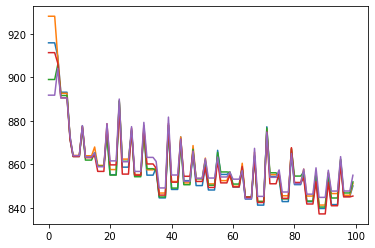

In [10]:
fig = plt.figure()
for i in range(num_students):
    plt.plot(loss_array[i])
plt.savefig("dml_convergence_3_1_100Epochs.png")

In [11]:
for i in range(num_students):
    evaluate_model(students[i])

This model has an average Dice of 0.6855 mit Variance: 0.06689. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.69626 mit Variance: 0.07129. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.69687 mit Variance: 0.06602. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.69827 mit Variance: 0.07016. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.69953 mit Variance: 0.06632. The unwarped Mean dice is: 0.64426 with Var 0.0769


In [15]:
for i in range(num_students):
    torch.save(students[i].state_dict(), f"student_{i}_dml_3_1_second.pth")

In [16]:
num_students = 5
students = []#torch.zeros(num_students, dtype=torch.nn.Module)#torch.zeros(num_students)
optims = []#torch.zeros(num_students)

for i in range(num_students):
    student = OBELISK2d(24)
    init_weights(student)
    student.train().cuda()
    
    optimizer = torch.optim.Adam(list(student.parameters()),lr=lr)
    
    students.append(student)
    optims.append(optimizer)
    
loss_array = torch.from_numpy(np.array([[0 for x in range(epochs)] for i in range(num_students)])).float()

In [18]:
for epoch in tqdm(range(epochs)):
    # Shuffle training examples
    rnd_train_idx = torch.randperm(train_set.size(0))

    # show all examples to model
    for rnd_idx in rnd_train_idx:
        
        p_fix = train_set[rnd_idx]

        # Get image and segmentation
        fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
        moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
        moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()
        
        # Label preparation
        C1,Hf,Wf = moving_seg.size()
        label_moving = F.one_hot(moving_seg,num_classes=3).permute(0,3,1,2).float()
        label_moving = F.interpolate(label_moving,size=(Hf//4,Wf//4),mode='bilinear')
        label_fixed = F.one_hot(fixed_seg,num_classes=3).permute(0,3,1,2).float()
        label_fixed = F.interpolate(label_fixed,size=(Hf//4,Wf//4),mode='bilinear')
        # generate the "unfolded" version of the moving encoding that will result in the shifted versions per channel
        # according to the corresponding discrete displacement pair
        label_moving_unfold = F.unfold(label_moving,(displace_range,displace_range),padding=disp_hw).view(1,3,displace_range**2,-1).cuda()
    
        outputs = []
        warped_labels = []
        fixed = Variable(fixed.cuda())
        moving = Variable(moving.cuda())
        
        # Forward pass
        for stud in students:
            
            feat_fixed = stud(fixed)
            feat_moving = stud(moving)

            ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
            soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
            
            # append the output
            outputs.append([soft_cost, disp_xy])
            
            label_warped = torch.sum(soft_cost.t().unsqueeze(0)*label_moving_unfold.squeeze(0),1)
            
            # store the warped prediction of the student
            warped_labels.append(label_warped.cpu())
        
        # Backward pass
        for idx, stud in enumerate(students):
            
            # calculate the individual label loss
            label_distance1 = torch.sum(torch.pow(label_fixed.reshape(3,-1)-warped_labels[idx].reshape(3,-1),2),0)
            
            loss_between_students = 0
            for run_idx in range(num_students):
                if idx != run_idx:
                    pred = Variable(outputs[run_idx][1])
                    # cauculate the loss between students
                    loss_between_students += torch.sum(torch.pow(outputs[idx][1] - pred, 2))
                    del(pred)
            
            loss = label_distance1.mean() + loss_between_students.mean() / (num_students)
            loss.backward()
            loss_array[idx][epoch] += loss.item()

        if (epoch+1)%grad_accum == 0:
            for optim in optims:
                optim.step()
                optim.zero_grad()

100%|██████████| 100/100 [1:30:04<00:00, 54.05s/it]


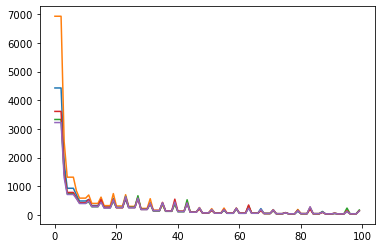

In [19]:
fig = plt.figure()
for i in range(num_students):
    plt.plot(loss_array[i])
plt.savefig("dml_convergence_3_2_100Epochs.png")

In [20]:
for i in range(num_students):
    evaluate_model(students[i])

This model has an average Dice of 0.67598 mit Variance: 0.0635. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67583 mit Variance: 0.06386. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67664 mit Variance: 0.06319. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67507 mit Variance: 0.06376. The unwarped Mean dice is: 0.64426 with Var 0.0769
This model has an average Dice of 0.67657 mit Variance: 0.06351. The unwarped Mean dice is: 0.64426 with Var 0.0769


In [21]:
for i in range(num_students):
    torch.save(students[i].state_dict(), f"student_{i}_dml_3_2.pth")

In [ ]:
import IPython
IPython.Application.instance().kernel.do_shutdown(True)